In [47]:
import pathlib
from tqdm import tqdm
import tqdm
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import time
import matplotlib.cm as cm
import scipy
import scipy.stats as st
import os

import sys
# Import these costom functions from the toolbox
sys.path.insert(1, './tools/')
import metrics
import signatures
import analysis_tools

In [2]:
# NOTEBOOK SETUP.
# CHOSE OPTIONS, PATHS, DATE RANGES, ETC. HERE IN THIS CELL

# Options for what to calculate
# Calulations will be saved to pkl
# If False, will load in pkl files
######################################
calculate_metric_dictionary = False #
calculate_flow_categories = False   #
calculate_metric_matrix = False     #
######################################

val_start='10/01/1989'
val_end='09/30/1999'
date_range = pd.date_range(start=val_start, end=val_end)

# Specifics about the analysis to use. 
all_metrics = ['NSE', 'Alpha-NSE', 'Pearson-r', 'Beta-NSE', 'FHV', 'FMS', 'FLV', 'Peak-Timing']
use_metrics = ['NSE', 'Beta-NSE', 'Peak-Timing']
metric_names = ['Nash-Sutcliffe Efficiency', 'Total bias', 'Peak timing error']
short_metric_names = ['NSE', 'Bias', 'Timing']
use_metric_names = ['Nash-Sutcliffe Efficiency', 'Total bias', 'Peak timing error']
use_metric_locs = [0,3,7]
# Plotting parameters for the metrics defined above.
disp_bounds = [(-0,1), (-0.2,0.1), (0,2)]
diff_bounds = [1, 0.2, 2]
optimal = [1, 0, 0]
disp_colors = {'base_model':'PRGn', 'lagged_streamflow_both':'PRGn'} 
#Alternative color scheme: 'PuOr'
disp_lims = {'base_model':[(0.2,1), (-0.2,0.1), (0,1.6)], 
             'base_model_states':[(0.2,1), (-0.2,0.1), (0,1.6)],
             'base_model_inputs':[(0.2,1), (-0.2,0.1), (0,1.6)],
             'base_model_both':[(0.2,1), (-0.2,0.1), (0,1.6)],
             'lagged_streamflow':[(0.2,1), (-0.2,0.1), (0,1.6)],
             'lagged_streamflow_states':[(0.2,1), (-0.2,0.1), (0,1.6)],
             'lagged_streamflow_inputs':[(0.2,1), (-0.2,0.1), (0,1.6)],
             'lagged_streamflow_both':[(0.2,1), (-0.2,0.1), (0,1.6)],
             'lagged_streamflow_both':[(0.2,1), (-0.08,0.04), (0,1.6)]}

# local directory with all data
# not included in github
data_dir = "./data/"

In [3]:
if True: # Open the attributes set up to do regression
    openthis = data_dir+'camels_attributes_v2.0/camels_attributes_v2.0_Regression.csv'
    attributes = pd.read_csv(openthis, sep=',', index_col='gauge_id')
else: # Open a slightly more extrnsive data set.
    openthis = data_dir+'camels_attributes_v2.0/camels_attributes_v2.0.csv'
    attributes = pd.read_csv(openthis, sep=';', index_col='gauge_id')

# Catchment attributes and hydrologic signatures that are not useful
drop_these = ['high_prec_timing','root_depth_50',
              'root_depth_99','zero_q_freq','water_frac','organic_frac']
    
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

# These are bad for the regression analysis.
attributes = attributes.drop(drop_these, axis=1)
attributes.shape

(671, 45)

In [4]:
# Get the hydrologic units for each basin.
with open(data_dir + 'usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
attributes['basin_hydro_unit'] = basin_hydro_unit

In [5]:
with open(data_dir+"ensemble_metrics.pkl", "rb") as fb:
    ensemble_metrics = pkl.load(fb)
with open(data_dir+"individual_run_metrics.pkl", "rb") as fb:
    individual_run_metrics = pkl.load(fb)
with open(data_dir+"observations.pkl", "rb") as fb:
    observations = pkl.load(fb)
with open(data_dir+"simulations.pkl", "rb") as fb:
    simulations = pkl.load(fb)

In [6]:
model_types = ensemble_metrics['NSE'].columns.values

In [7]:
basin_list = observations.columns.values

In [8]:
# Testing metric saved vs calculated
test_print_metrics=False
if test_print_metrics:
    print('calculated', nse(observations['01022500'], simulations['01022500', 'base_model']))
    print('ensemble_metrics', ensemble_metrics.loc['01022500',['NSE', 'base_model']][0])
    print('individual_run_metrics', individual_run_metrics.loc['01022500',['NSE', 'base_model']][0])

In [9]:
plot_lats = []
plot_lons = []
for i, b in enumerate(basin_list):
    plot_lats.append(attributes.loc[int(b),'gauge_lat'])
    plot_lons.append(attributes.loc[int(b),'gauge_lon'])
plot_lats = np.array(plot_lats)
plot_lons = np.array(plot_lons)

base_model_states


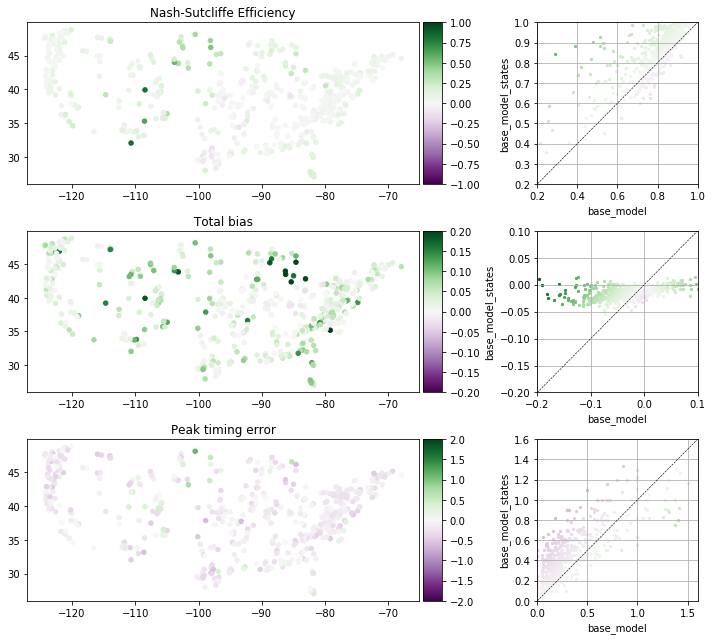

NSE
Number of improved basins = 430, 0.81%
Number of detrimented basins = 101, 0.19%
Beta-NSE
Number of improved basins = 431, 0.81%
Number of detrimented basins = 100, 0.19%
Peak-Timing
Number of improved basins = 50, 0.10%
Number of detrimented basins = 402, 0.81%


base_model_inputs


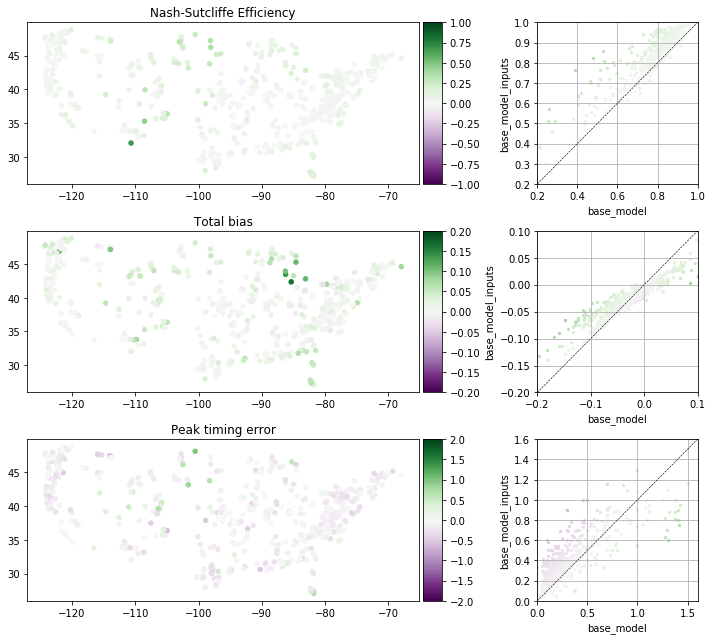

NSE
Number of improved basins = 492, 0.93%
Number of detrimented basins = 39, 0.07%
Beta-NSE
Number of improved basins = 410, 0.77%
Number of detrimented basins = 121, 0.23%
Peak-Timing
Number of improved basins = 61, 0.12%
Number of detrimented basins = 343, 0.69%


base_model_both


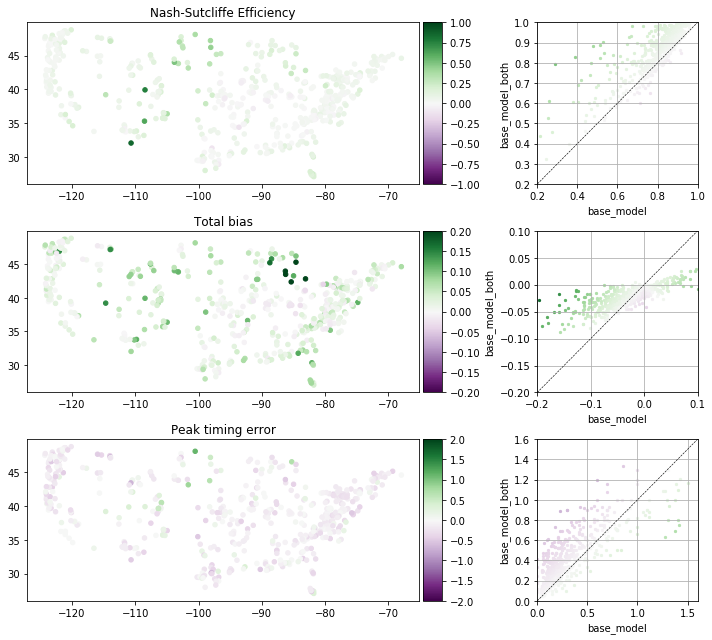

NSE
Number of improved basins = 466, 0.88%
Number of detrimented basins = 65, 0.12%
Beta-NSE
Number of improved basins = 416, 0.78%
Number of detrimented basins = 115, 0.22%
Peak-Timing
Number of improved basins = 53, 0.11%
Number of detrimented basins = 381, 0.77%


lagged_streamflow


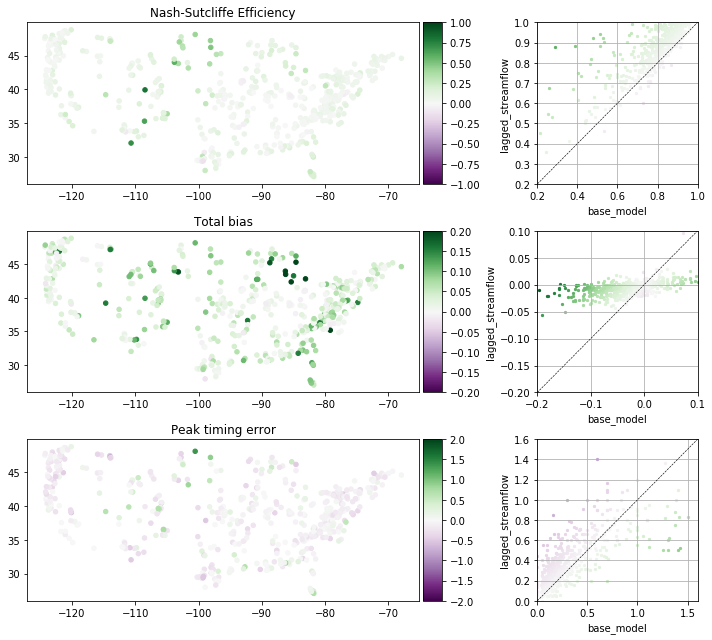

NSE
Number of improved basins = 498, 0.94%
Number of detrimented basins = 33, 0.06%
Beta-NSE
Number of improved basins = 468, 0.88%
Number of detrimented basins = 63, 0.12%
Peak-Timing
Number of improved basins = 78, 0.16%
Number of detrimented basins = 333, 0.67%


lagged_streamflow_states


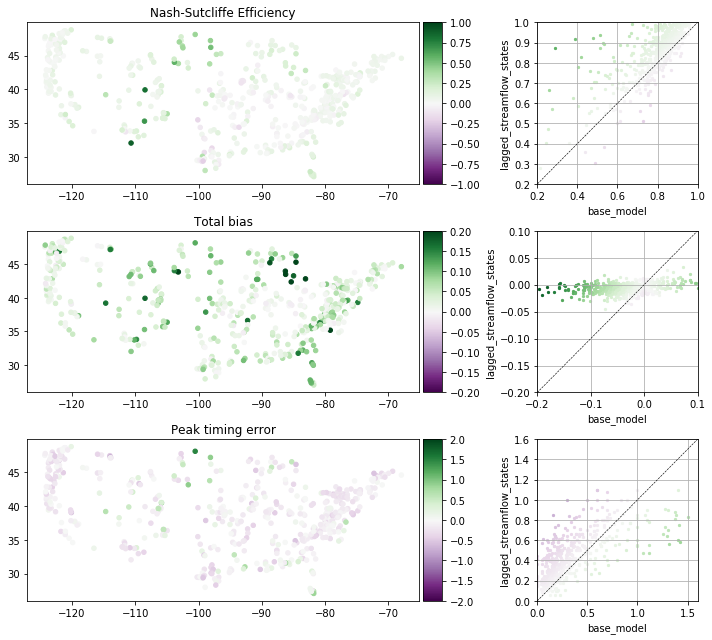

NSE
Number of improved basins = 438, 0.82%
Number of detrimented basins = 93, 0.18%
Beta-NSE
Number of improved basins = 469, 0.88%
Number of detrimented basins = 62, 0.12%
Peak-Timing
Number of improved basins = 64, 0.13%
Number of detrimented basins = 381, 0.77%


lagged_streamflow_inputs


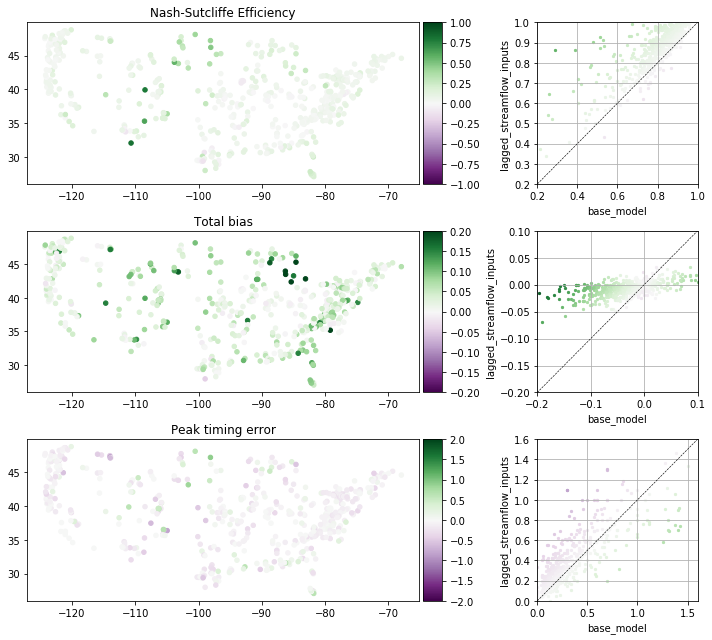

NSE
Number of improved basins = 494, 0.93%
Number of detrimented basins = 37, 0.07%
Beta-NSE
Number of improved basins = 462, 0.87%
Number of detrimented basins = 69, 0.13%
Peak-Timing
Number of improved basins = 75, 0.15%
Number of detrimented basins = 313, 0.63%


lagged_streamflow_both


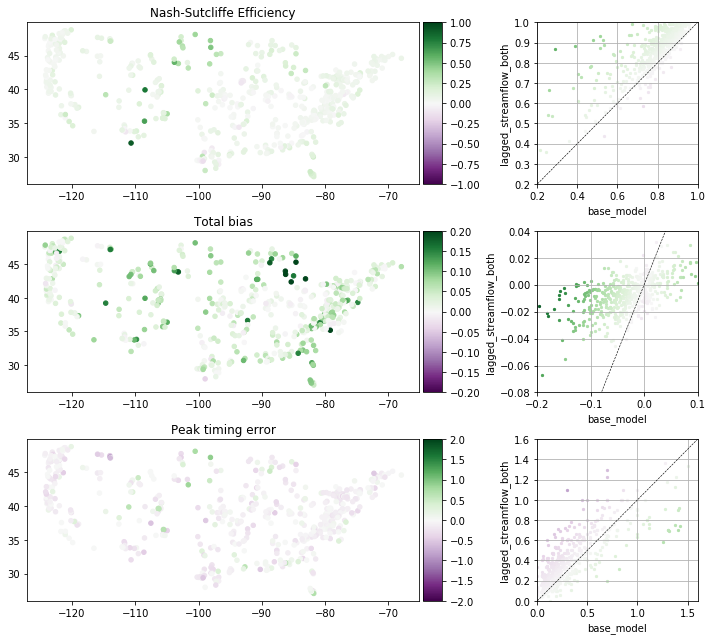

NSE
Number of improved basins = 489, 0.92%
Number of detrimented basins = 42, 0.08%
Beta-NSE
Number of improved basins = 465, 0.88%
Number of detrimented basins = 66, 0.12%
Peak-Timing
Number of improved basins = 81, 0.16%
Number of detrimented basins = 331, 0.67%




In [10]:
control='base_model'
percent=False
for test in model_types[1:]:

    print(test)

    diffs_inputs = (basin_list, ensemble_metrics, control, test, use_metrics, optimal, percent)
    performance_diffs = analysis_tools.DIFFS(diffs_inputs)

    plot_inputs = (disp_lims, disp_colors, disp_bounds, diff_bounds, plot_lons, plot_lats, use_metric_names)
    analysis_tools.PLOT_MAPS(diffs_inputs, performance_diffs, plot_inputs)

    analysis_tools.COUNT(diffs_inputs, performance_diffs)
    print('\n')

In [11]:
control='base_model'
corr_inputs = (ensemble_metrics, control, model_types, all_metrics)
df_corr = analysis_tools.CORR(corr_inputs)
print('Correlation of base model performance with model variations')
df_corr

Correlation of base model performance with model variations


,NSE,Alpha-NSE,Pearson-r,Beta-NSE,FHV,FMS,FLV,Peak-Timing
base_model,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
base_model_states,0.735970,0.672387,0.735167,0.338868,0.602764,1.0,0.827275,0.782679
base_model_inputs,0.889342,0.888864,0.874989,0.952600,0.873221,1.0,0.998255,0.817801
base_model_both,0.779241,0.768036,0.774916,0.797634,0.717165,1.0,0.980194,0.800824
lagged_streamflow,0.764081,0.777976,0.743523,0.566141,0.738327,1.0,0.665519,0.728912
lagged_streamflow_states,0.699200,0.537113,0.697134,0.369244,0.469435,1.0,0.692902,0.666734
lagged_streamflow_inputs,0.769533,0.784329,0.757609,0.603077,0.750705,1.0,0.660846,0.795237
lagged_streamflow_both,0.745715,0.751613,0.742407,0.597402,0.717619,1.0,0.660134,0.795092


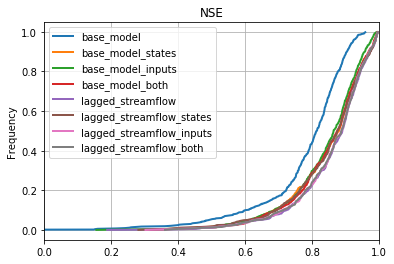

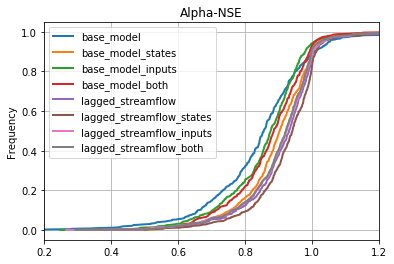

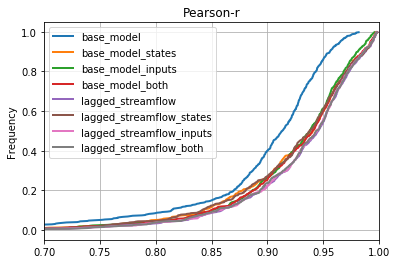

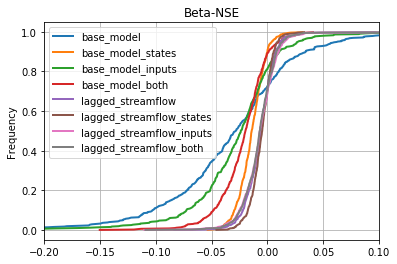

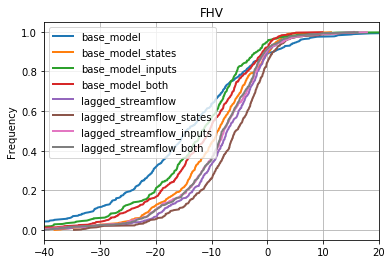

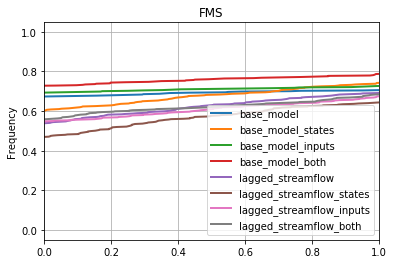

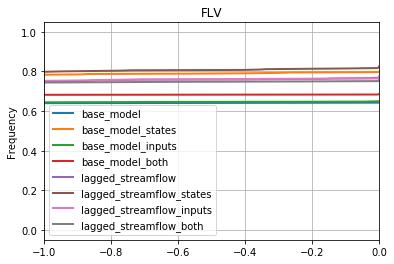

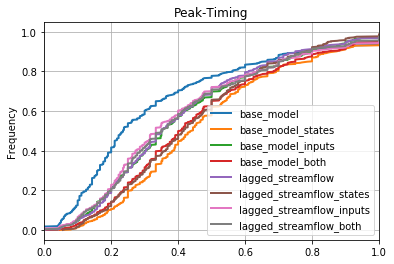

In [12]:
met_lims = {'NSE':[0,1], 'Alpha-NSE':[0.2,1.2], 'Pearson-r':[0.7, 1.0],
            'Beta-NSE':[-0.2,0.1], 'FHV':[-40,20], 'FMS':[0,1], 'FLV':[-1,0], 'Peak-Timing':[0,1]}

analysis_tools.PLOT_FREQ(basin_list, ensemble_metrics, all_metrics, model_types, met_lims)

In [13]:
# Get the days of the record that correspond to each flow type, for each basin.

flow_categories = ['all', 'rise', 'fall','above_mean', 'below_mean',
                       'above_mid', 'below_mid', 'below_20', 'above_80']

if calculate_flow_categories:
    
    flow_dates = analysis_tools.FLOW_CAT(basin_list, flow_categories, observations, date_range)
    
    with open(data_dir+'flow_category_dates.p','wb') as f:
        pkl.dump(flow_dates, f)
else:
    with open(data_dir+'flow_category_dates.p','rb') as f:
        flow_dates = pkl.load(f)

In [14]:
# But some of the metrics do not make sense when the flow is split up by category
#             i.e., the timing metrics don't make sense without consecutive days.
calc_metrics = all_metrics[0:4]

if calculate_metric_matrix:
    flow_mat, met_mat = analysis_tools.FLOW_METRICS(observations,
                 simulations,
                 calc_metrics,
                 basin_list,
                 model_types,
                 flow_categories, flow_dates)
    
    with open(data_dir+'metrics_matrix_v2.p','wb') as f:
            pkl.dump(met_mat, f)
    with open(data_dir+'flow_regime_matrix.p','wb') as f:
            pkl.dump(flow_mat, f)
else:
    with open(data_dir+'metrics_matrix_v2.p','rb') as f:
        met_mat = pkl.load(f)
    with open(data_dir+'flow_regime_matrix.p','rb') as f:
        flow_mat = pkl.load(f)

In [15]:
combined_metrics={fr:pd.DataFrame(index=model_types) for fr in flow_categories}
for fc in flow_categories:
    for imodel, model_name in enumerate(model_types):
        obs = np.array(flow_mat[fc]['obs'])
        sim = np.array(flow_mat[fc][model_name])
        combined_metrics[fc].loc[model_types[imodel],'nse']=analysis_tools.NSE(obs,sim)
        combined_metrics[fc].loc[model_types[imodel],'bias']=analysis_tools.BETA_NSE(obs,sim)
        combined_metrics[fc].loc[model_types[imodel],'variance']=analysis_tools.ALPHA_NSE(obs,sim)
        combined_metrics[fc].loc[model_types[imodel],'pearsonr'], _ = st.pearsonr(obs,sim)
combined_metrics

{'all':                                nse      bias  variance  pearsonr
 base_model                0.864273 -0.013530  0.909310  0.929991
 base_model_states         0.896687 -0.010368  0.912662  0.947638
 base_model_inputs         0.895795 -0.014442  0.902497  0.947651
 base_model_both           0.897357 -0.013475  0.902907  0.948481
 lagged_streamflow         0.906800 -0.004317  0.933604  0.952457
 lagged_streamflow_states  0.898325 -0.004572  0.931180  0.947960
 lagged_streamflow_inputs  0.905431 -0.004140  0.928420  0.951839
 lagged_streamflow_both    0.905041 -0.004656  0.925144  0.951719,
 'rise':                                nse      bias  variance  pearsonr
 base_model                0.837024 -0.027917  0.874178  0.916284
 base_model_states         0.862864 -0.045690  0.841291  0.934708
 base_model_inputs         0.861896 -0.040796  0.845782  0.933401
 base_model_both           0.862144 -0.045332  0.837329  0.934710
 lagged_streamflow         0.876159 -0.030697  0.879755  0.9

In [16]:
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('expand_frame_repr', False)
for fc in flow_categories:
    print('\n'+fc)
    G = [np.nanmean(met_mat[fc][:,i,0]) for i,mt in enumerate(model_types)]
    H = [np.nanmedian(met_mat[fc][:,i,0]) for i,mt in enumerate(model_types)]
    I = [np.nanmedian(met_mat[fc][:,i,1]) for i,mt in enumerate(model_types)]
    J = [np.nanmedian(met_mat[fc][:,i,2]) for i,mt in enumerate(model_types)]
    K = [np.nanmedian(met_mat[fc][:,i,3]) for i,mt in enumerate(model_types)]
    df = pd.DataFrame(data=np.array([G, H, I, J, K]).reshape(5,len(model_types)).transpose(),
                      index=model_types,  
            columns=['NSE(mean)','NSE(median)','Beta-NSE','Alpha-NSE','Pearsonr'])
    print(df)


all
                          NSE(mean)  NSE(median)  Beta-NSE  Alpha-NSE  Pearsonr
base_model                  0.77796      0.81483   0.85593    0.91303  -0.02860
base_model_states           0.84497      0.88025   0.90345    0.94078  -0.01402
base_model_inputs           0.83810      0.86403   0.87624    0.93807  -0.02386
base_model_both             0.84631      0.87483   0.88534    0.94017  -0.01966
lagged_streamflow           0.85934      0.89045   0.93113    0.94558  -0.00612
lagged_streamflow_states    0.84503      0.87614   0.94115    0.93775  -0.00467
lagged_streamflow_inputs    0.85678      0.88789   0.92378    0.94454  -0.00676
lagged_streamflow_both      0.85701      0.88719   0.92185    0.94342  -0.00691

rise
                          NSE(mean)  NSE(median)  Beta-NSE  Alpha-NSE  Pearsonr
base_model                  0.75370      0.79029   0.82785    0.90601  -0.04793
base_model_states           0.81802      0.84208   0.83621    0.93227  -0.05959
base_model_inputs           0

In [30]:
model_types[1:]

array(['base_model_states', 'base_model_inputs', 'base_model_both',
       'lagged_streamflow', 'lagged_streamflow_states',
       'lagged_streamflow_inputs', 'lagged_streamflow_both'], dtype=object)

In [39]:
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('expand_frame_repr', False)
for fc in flow_categories:
    print(fc)
    wilcoxcon_list = [analysis_tools.WILCOXON(fc, i, model_types[1:]) for i in range(4)]
    df = pd.DataFrame(data=np.array(wilcoxcon_list).reshape(4,7).transpose(),
                      index=model_types[1:],  
            columns=['NSE','Beta-NSE','Alpha-NSE','Pearsonr'])
    print(df)
    print('\n')


all
                             NSE  Beta-NSE  Alpha-NSE  Pearsonr
base_model_states        0.00000   0.00000    0.00000   0.00000
base_model_inputs        0.00000   0.00039    0.00000   0.00123
base_model_both          0.00000   0.00000    0.00000   0.00000
lagged_streamflow        0.00000   0.00000    0.00000   0.00000
lagged_streamflow_states 0.00000   0.00000    0.00000   0.00000
lagged_streamflow_inputs 0.00000   0.00000    0.00000   0.00000
lagged_streamflow_both   0.00000   0.00000    0.00000   0.00000


rise
                             NSE  Beta-NSE  Alpha-NSE  Pearsonr
base_model_states        0.00000   0.37501    0.00000   0.00000
base_model_inputs        0.00000   0.00000    0.00000   0.00000
base_model_both          0.00000   0.00002    0.00000   0.00000
lagged_streamflow        0.00000   0.00000    0.00000   0.00252
lagged_streamflow_states 0.00000   0.00000    0.00000   0.83539
lagged_streamflow_inputs 0.00000   0.00000    0.00000   0.00080
lagged_streamflow_both   0.00

In [59]:
# Calculate the hydrologic signatures for all the models, and see which is closer to the observation.
sigs = signatures.get_available_signatures()
nsigs = len(sigs)
obs_model_types = ['obs']+[i for i in model_types]
sigs_dict = {imod:pd.DataFrame(index=basin_list, 
                               data=np.full([len(basin_list),nsigs],np.nan), 
                               columns=sigs) for imod in obs_model_types}

nldas_dir = './data/basin_dataset_public_v1p2/basin_mean_forcing/nldas_extended/'

for root, subdirs, files in os.walk(nldas_dir):
    for file in files:
        file_path = os.path.join(root, file)
        b = file[0:8]
        if b not in flow_dates['all'].keys():
            continue
        flow_set = flow_dates['all'][b]
        hu = attributes.loc[int(b), 'basin_hydro_unit']
        with open(file_path, 'r') as f:
            df = pd.read_csv(f, sep="\s+",header=3)
        dti = pd.date_range(val_start, periods=df.shape[0], freq='D')
        df['date'] = dti
        df = df.set_index('date')
        prcp=xr.DataArray(df['PRCP(mm/day)'])

        for imt, model_type in enumerate(['nwm', 'v0','v2']):
            xsim = xr.DataArray(ensemble_q_dictionary[model_type][b].loc[flow_set]).rename({'dim_0': 'date'})
            sigs_dict[model_type].loc[b,:] = signatures.calculate_all_signatures(da=xsim, prcp=prcp)
            
        xobs = xr.DataArray(lstm_sample[b].loc[flow_set, 'qobs']).rename({'dim_0': 'date'})
        sigs_dict['obs'].loc[b,:] = signatures.calculate_all_signatures(da=xobs, prcp=prcp)

In [57]:
sigs_dict

{'obs':           high_q_freq  high_q_dur  low_q_freq  low_q_dur  zero_q_freq  q95  q5  q_mean  hfd_mean  baseflow_index  slope_fdc  stream_elas  runoff_ratio
 01022500          nan         nan         nan        nan          nan  nan nan     nan       nan             nan        nan          nan           nan
 01031500          nan         nan         nan        nan          nan  nan nan     nan       nan             nan        nan          nan           nan
 01047000          nan         nan         nan        nan          nan  nan nan     nan       nan             nan        nan          nan           nan
 01052500          nan         nan         nan        nan          nan  nan nan     nan       nan             nan        nan          nan           nan
 01054200          nan         nan         nan        nan          nan  nan nan     nan       nan             nan        nan          nan           nan
 ...               ...         ...         ...        ...          ...  ...  ..  